In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity

import glob
from tqdm import tqdm  # progress bar

# Step 1

## Making initial map

In [4]:
step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "CTCGAGATAACTTCGTATAATGTATGCTAT",
                       post = "GGCCGGCCATAGGGCCCC",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "GAGCTCGCTAGC",
                       post = "CTCGAGATAA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GGCCGGCCATAGGGCCCC",
                       post = "GCGGTCCA",
                       length = 16)

step1_AD = finder.Barcode(name = "AD",
                       preceder = "CACCATG",
                       post = "GGATCCG",
                       length = 162)

In [11]:
mapper = initial_map.InitialMapper(db_path = "../../duckdb/NKX2-2-full.db",
                       seq_file = ['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq'],
                        bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                        reverse_complement=False,
                        step_name = "step1",
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt")

In [13]:
mapper.create_map()
mapper.preview_map()

Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.59 minutes.

Done in 0.00 seconds.

Extracting 4 barcodes...
Regex for ADBC2: CTCGAGATAACTTCGTATAATGTATGCTAT(.*)GGCCGGCCATAGGGCCCC


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Regex for HawkBCs: GAGCTCGCTAGC(.*)CTCGAGATAA


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Regex for RTBC: GGCCGGCCATAGGGCCCC(.*)GCGGTCCA


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Regex for AD: CACCATG(.*)GGATCCG


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 28.47 seconds.

Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 18.91 seconds.

Mapping complete.
step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 15252011


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,AGCCCC,True,AGTCCAGTT,True,GCAACTATTAGTAACT,True,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGGC...,True,1
1,TTCAAG,True,AACCAGAAC,True,CCTTTCAAACTGACAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,AAAGTT,True,AGCTGTTGG,True,ATAATGTACAATTACC,True,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,True,1
3,GTCGCA,True,AACCAGAAC,True,TCACACGTCACAACAA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
4,CGTAAA,True,AGGAGTATG,True,CATTTATAGAGTAATT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGGCCCAGG...,True,1


In [19]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full.db",
                                bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                                reads_threshold = 100,
                                map_order = ['grouped', 'barcode_exists', 'thresholded', 'unique_target', 'quality', 'designed'],
                                step_name = "step1",
                                output_figures_path="../../output/NKX2-2_step1_figs/",
                                min_fraction_major_target= 0.9,
                                descriptor = "overlap_prop")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. grouped
3. barcode_exists
4. thresholded
5. unique_target
6. quality
7. designed



Grouping step1_ADBC2_HawkBCs_RTBC_AD_initial...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

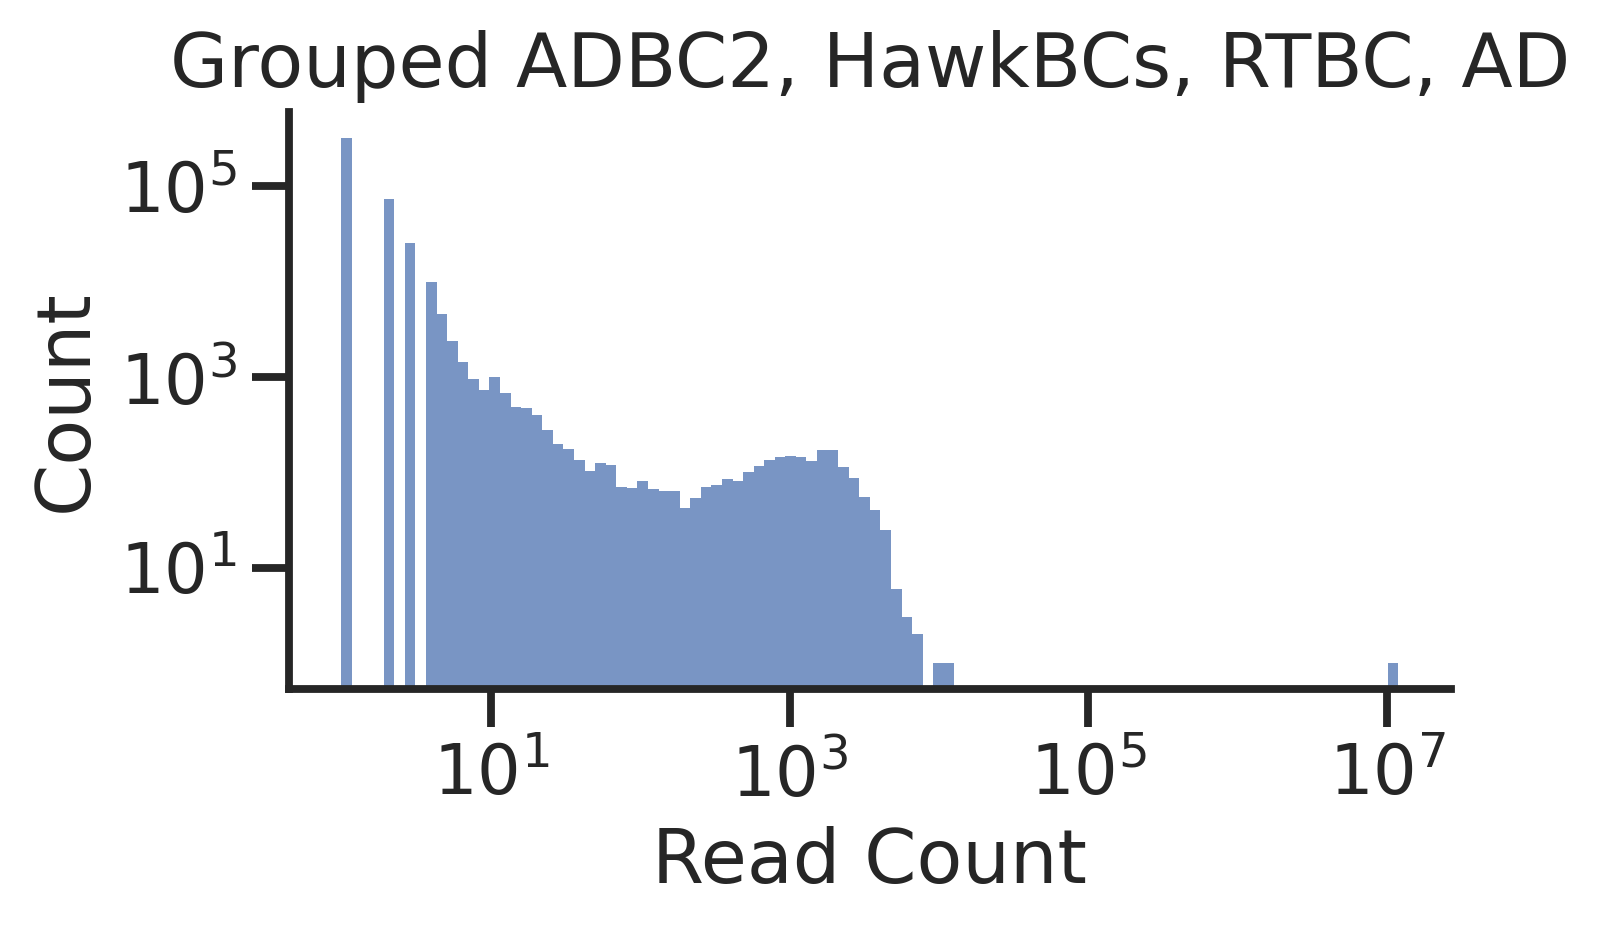

Done in 6.55 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 2.08 seconds.

Thresholding...
Using reads threshold of 100.


In [ ]:
refiner.refine_map_from_db()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.39 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.31 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

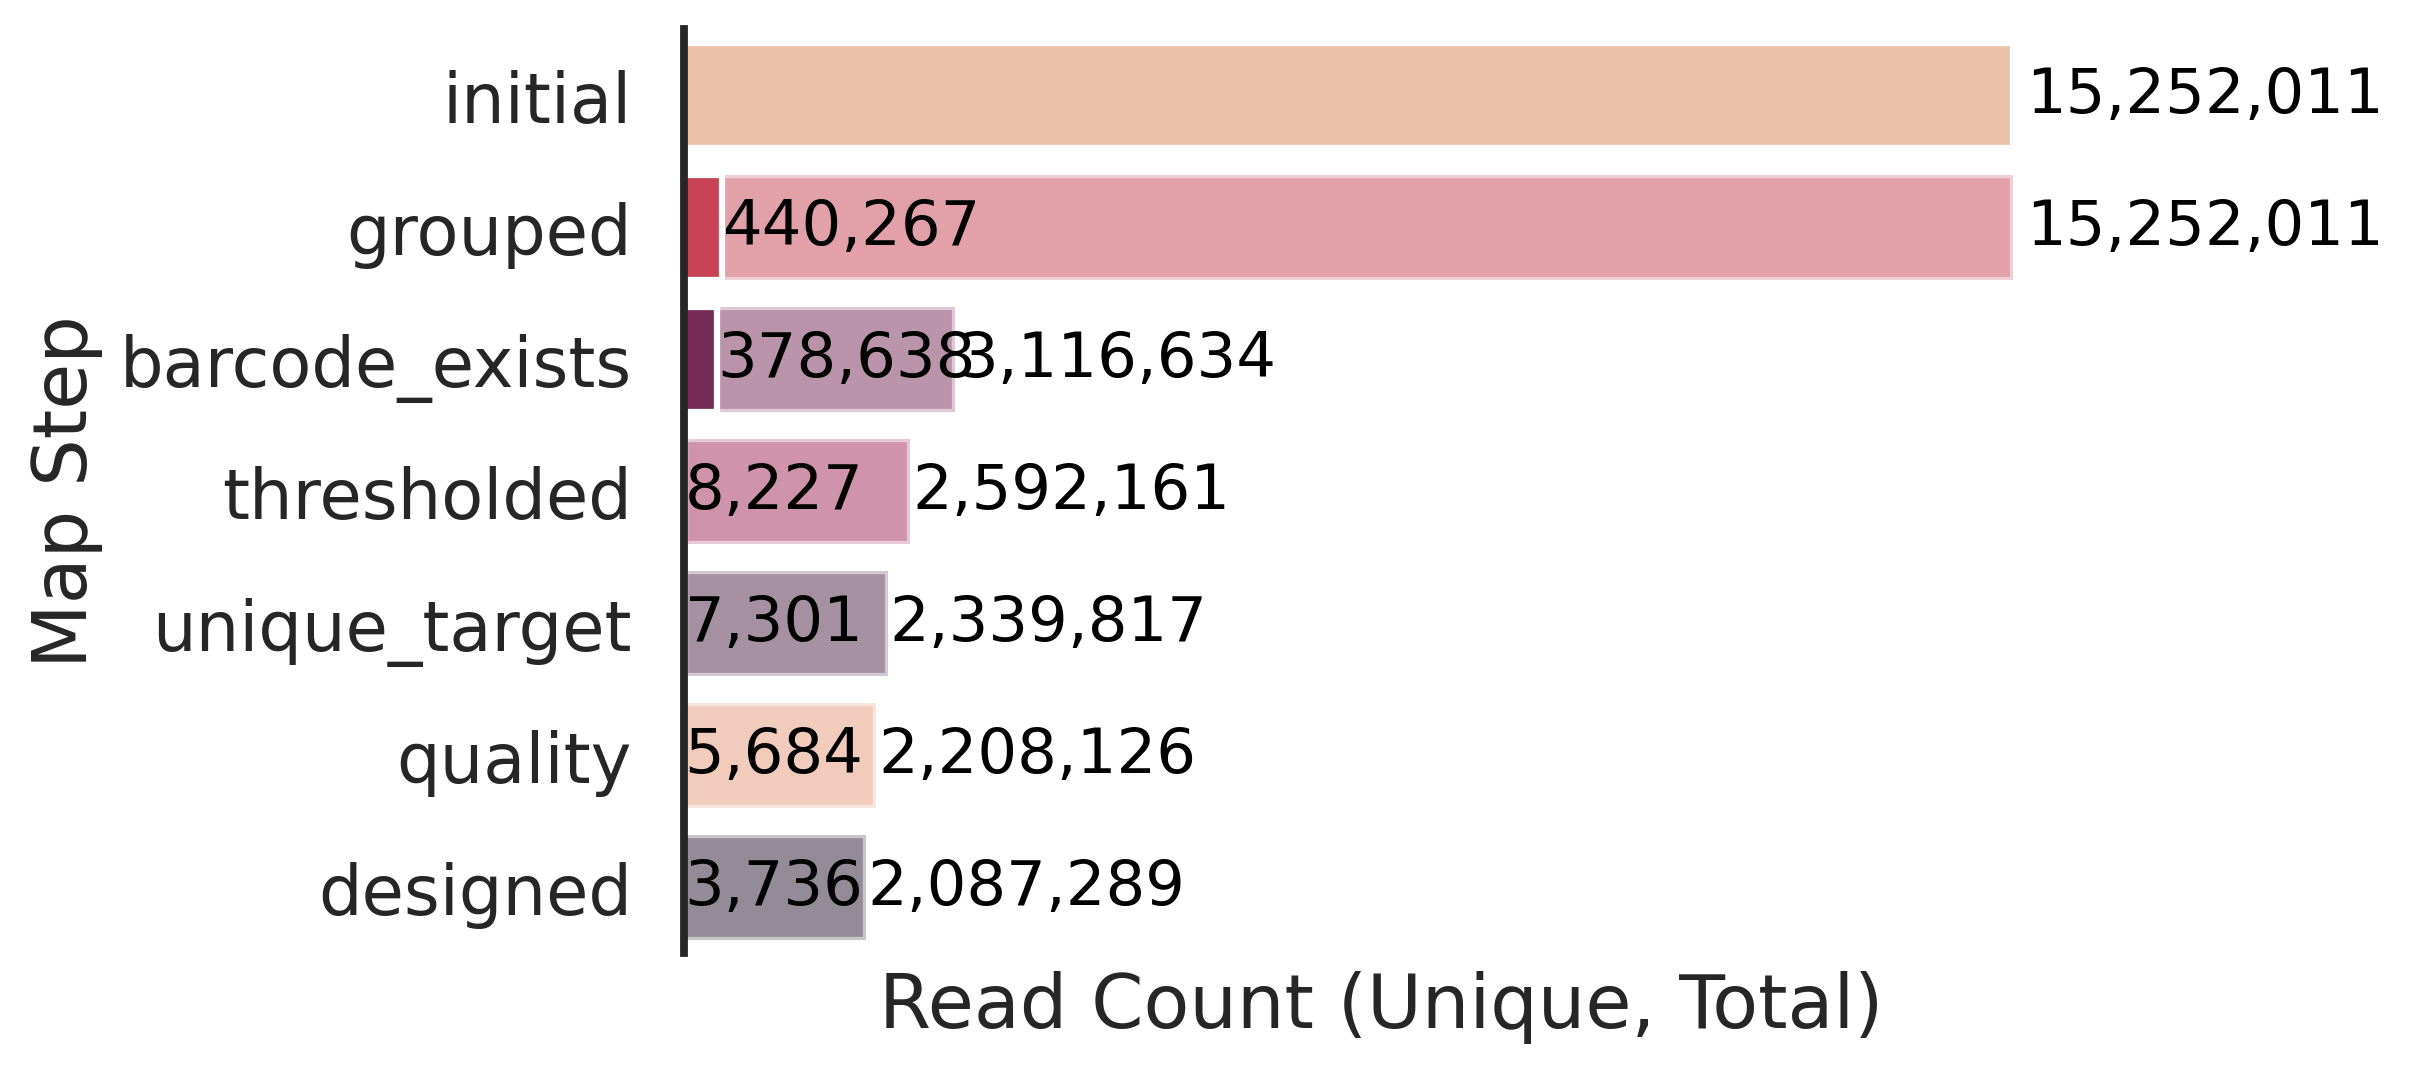

In [18]:
refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.14 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.11 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

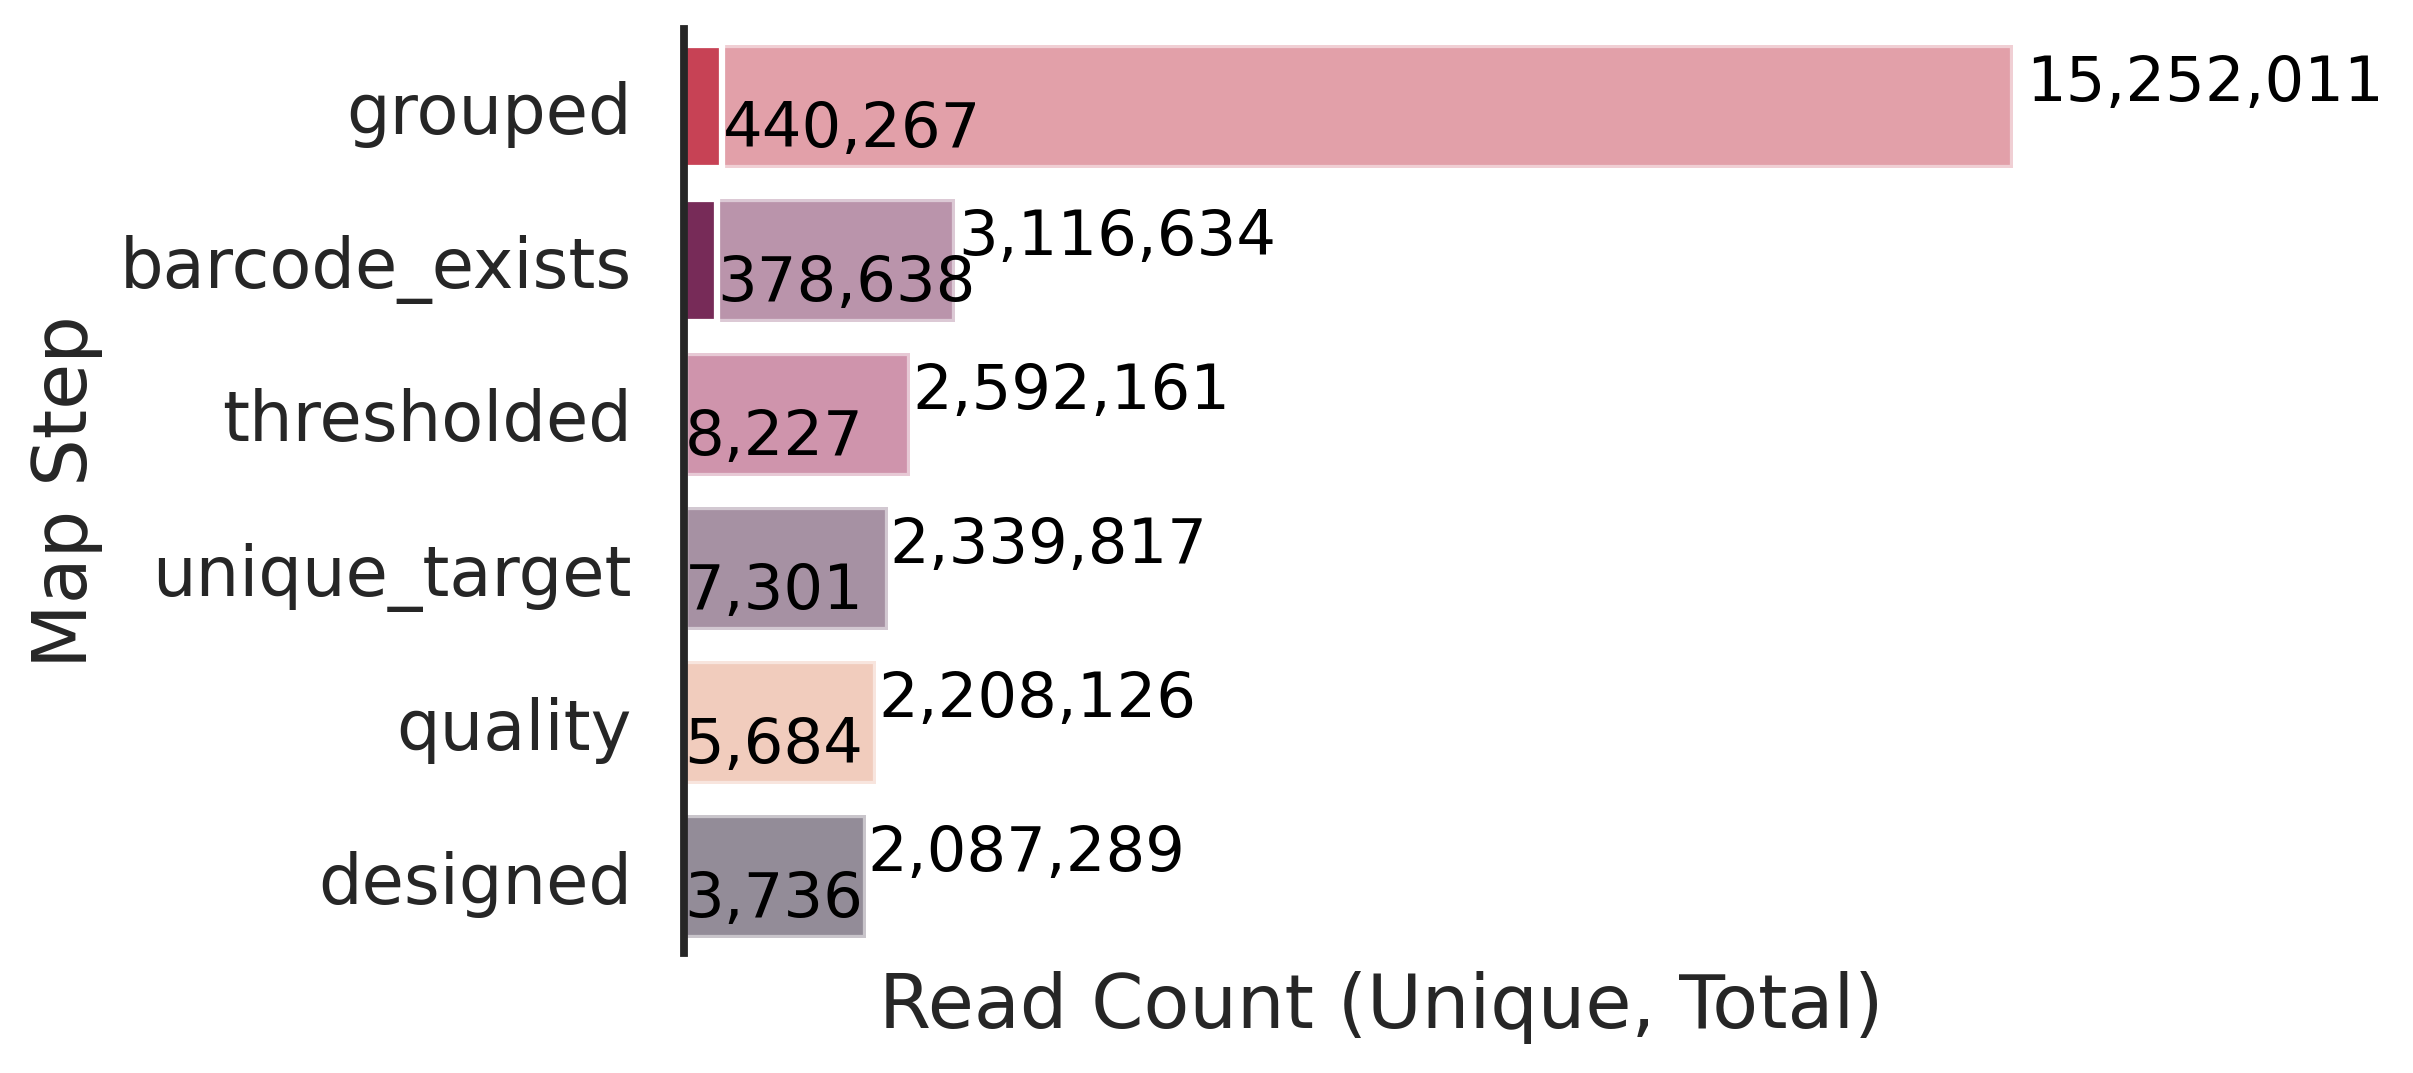

In [7]:
refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

In [36]:
refiner.get_map_df('quality_designed').to_csv("../../output/NKX2-2_whitelist_step1_map.csv")

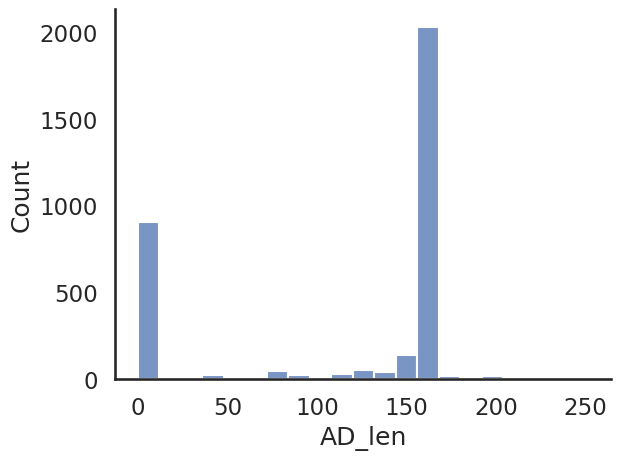

In [226]:
unique_target = refiner.get_map_df('unique_target')
unique_target_undesigned = unique_target[unique_target["Designed"] == 0]
unique_target_undesigned_qual_bcs = unique_target_undesigned[(unique_target_undesigned["ADBC2_qual"]) & (unique_target_undesigned["HawkBCs_qual"]) & (unique_target_undesigned["RTBC_qual"])]
unique_target_undesigned_qual_bcs["AD_len"] = unique_target_undesigned_qual_bcs["AD"].str.len()
unique_target_undesigned_qual_bcs_len_divis_3 = unique_target_undesigned_qual_bcs[unique_target_undesigned_qual_bcs["AD_len"] % 3 == 0]
unique_target_undesigned_qual_bcs_len_divis_3_no_stop = unique_target_undesigned_qual_bcs_len_divis_3[~unique_target_undesigned_qual_bcs_len_divis_3["AD"].str.contains("TAA")]
sns.histplot(unique_target_undesigned_qual_bcs_len_divis_3_no_stop["AD_len"], binwidth = 12)
sns.despine()

In [227]:
unique_target_undesigned_qual_bcs_len_divis_3_no_stop

,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed,AD_len
27,CCTAGC,CCAAGGTGT,GTCGGATATTCATCCA,AGACTGCTGGGCCAGAGCATGGACGAGAGCGGCCTGCCTCAGCTGA...,4310,True,True,True,True,0,162
34,TCATAT,CAATCTCTC,AACAGGAAACATGAAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...,4072,True,True,True,True,0,162
51,TGAGTT,AACGAATGC,AAGACATACGAGCTAT,GCCGAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3736,True,True,True,True,0,162
61,TTGTGA,CCATCGACA,CTAAATACATAACTTA,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,3598,True,True,True,True,0,162
137,CAAGCA,CCATATTCG,TTAAACAACGTAATTG,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,2818,True,True,True,False,0,165
...,...,...,...,...,...,...,...,...,...,...,...
10381,TAGTTC,ACCTCGATT,AAGGTTAAACACCTTC,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,6,True,True,True,True,0,162
10382,AAAGTT,CATGTTGCC,AAAATTATTGAGAAGC,GCCCAGGACCTGGCCCAGCAGACCTTCCAGGCCGGCATTCCCTTCA...,6,True,True,True,True,0,162
10385,GTATTG,AAGGATCTG,GATTTATGTACGGGAC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCC...,6,True,True,True,True,0,162
10388,TCAACC,CACTCGGAA,TGAACGGACAAGCGAA,GCCTTCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6,True,True,True,True,0,162


In [228]:
sum(unique_target_undesigned_qual_bcs_len_divis_3_no_stop["count"])

166709

In [97]:
# grouped = refiner.get_map_df('grouped')
# grouped

In [98]:
# grouped.to_csv("../../data/NKX2-2_grouped.csv")

In [99]:
refiner.get_map_df('unique_target')

,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed,computed_key,computed_target,computed_key_1,computed_target_1
0,AGTCCC,ACGACCATA,CCTCCATCATTTCGTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,109,True,True,True,True,1,AGTCCC-ACGACCATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,CCTCCATCATTTCGTC,AGTCCC-ACGACCATA
1,ACCATA,AGTCCAGTT,TCACACGAAAAGTATA,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGGC...,108,True,True,True,True,1,ACCATA-AGTCCAGTT,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGGC...,TCACACGAAAAGTATA,ACCATA-AGTCCAGTT
2,GAGAAT,ACGGTCCAA,AGCAAAATGGAAAAAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCGCCA...,106,True,True,True,True,1,GAGAAT-ACGGTCCAA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCGCCA...,AGCAAAATGGAAAAAT,GAGAAT-ACGGTCCAA
3,ATATTC,ACAATACGG,ATGAGCATACTAGTGC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,105,True,True,True,True,1,ATATTC-ACAATACGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,ATGAGCATACTAGTGC,ATATTC-ACAATACGG
4,AACCCG,CATCTTAGG,TGTGGATGCGGTTATT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,104,True,True,True,True,1,AACCCG-CATCTTAGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,TGTGGATGCGGTTATT,AACCCG-CATCTTAGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6556,CTCCGT,ACGTATCGG,CATTAGTACTTGCTAC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,128,True,True,True,True,1,CTCCGT-ACGTATCGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,CATTAGTACTTGCTAC,CTCCGT-ACGTATCGG
6557,TATATA,AGCATCATC,CAAAATCGCGTATATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,125,True,True,True,True,1,TATATA-AGCATCATC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,CAAAATCGCGTATATA,TATATA-AGCATCATC
6558,ACATAA,ATGTTGAGG,TTTAGAATAAATCCCC,GCCCAGGACCTGGCCGCCGCCGAGTTCCAGGCCGGCATTCCCTTCA...,125,True,True,True,True,1,ACATAA-ATGTTGAGG,GCCCAGGACCTGGCCGCCGCCGAGTTCCAGGCCGGCATTCCCTTCA...,TTTAGAATAAATCCCC,ACATAA-ATGTTGAGG
6559,AGTCCT,AATAGCTGG,AGATTATGGAAAAGAA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,114,True,True,True,True,1,AGTCCT-AATAGCTGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGATTATGGAAAAGAA,AGTCCT-AATAGCTGG


In [128]:
thresholded = refiner.get_map_df('thresholded')
thresholded

,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,11172,True,True,True,True,1
1,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,9261,True,True,True,True,1
2,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,7239,True,True,True,True,1
3,TGGGAC,ACCGGATGT,CACAAAACGTGGCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,7042,True,True,True,True,1
4,CTAATA,ATCAGGACC,CAGGAAATCCCTCTAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,6387,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...
43355,GAAGAC,ACTCGTCGT,TTTACACCTAGGAAAG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1
43356,CAAGGT,AAGGTACGT,GAATATCGCGAGGTGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1
43357,TTTAAC,AGCTACCAA,CTGACTCAATTAAACT,GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1
43358,TACCAC,AGCTACCAA,GGTGGGTGGTACGTTG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,False,0


In [158]:
# First ADBCs filtering
thresholded["concat_ADBCs"] = thresholded["ADBC2"] + thresholded["HawkBCs"]
unique_ADBCs_AD_pairs = pd.DataFrame(thresholded[["concat_ADBCs", "AD", "count"]].groupby(["concat_ADBCs", "AD"])["count"].sum()).reset_index()
unique_ADBCs_AD_pairs

,concat_ADBCs,AD,count
0,AAAAAAAACCGCATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,308
1,AAAAAAAACCGCATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
2,AAAAAAACAAGAAGC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
3,AAAAAAACGTAAGCA,GCCCTGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
4,AAAAAAACTCTTGCA,,3
...,...,...,...
41346,TTTTTTATAGGAGTT,GCCCAGGACCTTGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,8
41347,TTTTTTATCGCCTTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,5
41348,TTTTTTATTACGCTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
41349,TTTTTTCCAACACTA,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,4


In [159]:
# compute total reads per concat_ADBCs
total_counts = unique_ADBCs_AD_pairs.groupby("concat_ADBCs")["count"].sum().rename("total_count")
total_counts

concat_ADBCs
AAAAAAAACCGCATA    311
AAAAAAACAAGAAGC      3
AAAAAAACGTAAGCA      3
AAAAAAACTCTTGCA    827
AAAAAAAGTGTGCGT     34
                  ... 
TTTTTTATAGGAGTT      8
TTTTTTATCGCCTTC      5
TTTTTTATTACGCTC      3
TTTTTTCCAACACTA      4
TTTTTTCCGATCTAT     67
Name: total_count, Length: 8565, dtype: int64

In [160]:
# get max AD count per concat_ADBCs
max_counts = unique_ADBCs_AD_pairs.groupby("concat_ADBCs")["count"].max().rename("max_count")
max_counts

concat_ADBCs
AAAAAAAACCGCATA    308
AAAAAAACAAGAAGC      3
AAAAAAACGTAAGCA      3
AAAAAAACTCTTGCA    792
AAAAAAAGTGTGCGT     34
                  ... 
TTTTTTATAGGAGTT      8
TTTTTTATCGCCTTC      5
TTTTTTATTACGCTC      3
TTTTTTCCAACACTA      4
TTTTTTCCGATCTAT     67
Name: max_count, Length: 8565, dtype: int64

In [161]:
# merge back
df_summary = pd.concat([total_counts, max_counts], axis=1)
df_summary["max_fraction"] = df_summary["max_count"] / df_summary["total_count"]
df_summary

,total_count,max_count,max_fraction
concat_ADBCs,,,
AAAAAAAACCGCATA,311,308,0.990354
AAAAAAACAAGAAGC,3,3,1.000000
AAAAAAACGTAAGCA,3,3,1.000000
AAAAAAACTCTTGCA,827,792,0.957678
AAAAAAAGTGTGCGT,34,34,1.000000
...,...,...,...
TTTTTTATAGGAGTT,8,8,1.000000
TTTTTTATCGCCTTC,5,5,1.000000
TTTTTTATTACGCTC,3,3,1.000000


In [162]:
# filter to those where >90% of reads come from most abundant AD
valid_ADBCs = df_summary[df_summary["max_fraction"] > 0.9].index

# filter original df
filtered_df = unique_ADBCs_AD_pairs[unique_ADBCs_AD_pairs["concat_ADBCs"].isin(valid_ADBCs)].copy()
filtered_df

,concat_ADBCs,AD,count
0,AAAAAAAACCGCATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,308
1,AAAAAAAACCGCATA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
2,AAAAAAACAAGAAGC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
3,AAAAAAACGTAAGCA,GCCCTGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
4,AAAAAAACTCTTGCA,,3
...,...,...,...
41346,TTTTTTATAGGAGTT,GCCCAGGACCTTGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,8
41347,TTTTTTATCGCCTTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,5
41348,TTTTTTATTACGCTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3
41349,TTTTTTCCAACACTA,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,4


In [157]:
# First RPTR BCs filtering
unique_RPBC_AD_pairs = pd.DataFrame(thresholded[["RTBC", "AD", "count"]].groupby(["RTBC", "AD"])["count"].sum()).reset_index()

# compute total reads per concat_ADBCs
total_counts = unique_RPBC_AD_pairs.groupby("RTBC")["count"].sum().rename("total_count")

# get max AD count per concat_ADBCs
max_counts = unique_RPBC_AD_pairs.groupby("RTBC")["count"].max().rename("max_count")

# merge back
df_summary = pd.concat([total_counts, max_counts], axis=1)
df_summary["max_fraction"] = df_summary["max_count"] / df_summary["total_count"]

# filter to those where >90% of reads come from most abundant AD
valid_RTBCs = df_summary[df_summary["max_fraction"] > 0.9].index
valid_RTBCs

Index(['AAAAAAAACATTGACA', 'AAAAAAAGAGAAGCAA', 'AAAAAAATAAACAATG',
       'AAAAAAATAAGCAATG', 'AAAAAAATAATCAATG', 'AAAAAACCCTTAAGTA',
       'AAAAAACCCTTAATTA', 'AAAAAACTAGCTTAAG', 'AAAAAAGACATTGACA',
       'AAAAAAGAGATTGACA',
       ...
       'TTTTCTAGCATAACCG', 'TTTTGCTATCAATATG', 'TTTTTAAATCAAAGGT',
       'TTTTTAATTACAATAA', 'TTTTTAGACGTCATCT', 'TTTTTAGCCGTCATCT',
       'TTTTTAGCGAGAATTG', 'TTTTTATCCGTCATCT', 'TTTTTGAGAAATAAAG',
       'TTTTTTCGCCAAGACC'],
      dtype='object', name='RTBC', length=2925)

In [165]:
thresholded[(thresholded["concat_ADBCs"].isin(valid_ADBCs)) & (thresholded["RTBC"].isin(valid_RTBCs))]

,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed,concat_ADBCs
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,11172,True,True,True,True,1,CCATAACACCGATTG
1,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,9261,True,True,True,True,1,GTCAGCCCATTAACG
2,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,7239,True,True,True,True,1,GTACAACCATCGGTT
5,ATACGA,ACCATTAGG,TAGTAATATTCGCAAG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,5787,True,True,True,True,1,ATACGAACCATTAGG
7,GCGCTT,ATTCTCGCC,CAATATTCCGGCGACT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,5155,True,True,True,True,1,GCGCTTATTCTCGCC
...,...,...,...,...,...,...,...,...,...,...,...
43353,TCTAGA,AGACCTTCA,CATATCGGAATTCTCT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1,TCTAGAAGACCTTCA
43354,ACAGAC,ACAAGCGTT,CGATAATTTAGAATGT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1,ACAGACACAAGCGTT
43357,TTTAAC,AGCTACCAA,CTGACTCAATTAAACT,GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,True,1,TTTAACAGCTACCAA
43358,TACCAC,AGCTACCAA,GGTGGGTGGTACGTTG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,3,True,True,True,False,0,TACCACAGCTACCAA


In [144]:
# # Matches caitlin's starting point!
# barcode_exists = refiner.get_map_df('barcode_exists')
# barcode_exists[barcode_exists["AD_qual"] & barcode_exists["HawkBCs_qual"] & barcode_exists["RTBC_qual"] & barcode_exists["ADBC2_qual"] & (barcode_exists["Designed"] == 1)]

In [34]:
final = refiner.get_map_df("quality_designed")
final = final[final["count"] > 10]
final

,ADBC2,HawkBCs,RTBC,AD,count,ADBC2_qual,HawkBCs_qual,RTBC_qual,AD_qual,Designed,computed_key,computed_target
0,GAGTTC,AGCTTACGG,GGGACGAGACGCTGCA,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,966,True,True,True,True,1,GAGTTC-AGCTTACGG,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...
1,GTCAAG,CAGTTACAC,AAATTGGAGCCATTTA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,715,True,True,True,True,1,GTCAAG-CAGTTACAC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
2,AACACC,ATTCTCGCC,AAATTCAAGCCATGGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,675,True,True,True,True,1,AACACC-ATTCTCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...
3,GCTATT,ATTCGGTTC,TTTGTAAAAAATGTAC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,648,True,True,True,True,1,GCTATT-ATTCGGTTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
4,CACTGC,CATCCACTA,GATCGGGACTACTTGC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,631,True,True,True,True,1,CACTGC-CATCCACTA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...,...,...,...,...,...,...,...,...,...
292,TGGGAC,ACAGGATGT,CACAAAACGTGGCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,11,True,True,True,True,1,TGGGAC-ACAGGATGT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
293,GATTCT,ATGCTCAGT,TCACACCCAAGACCGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,11,True,True,True,True,1,GATTCT-ATGCTCAGT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
294,CTCTAC,ACCATTAGG,CGGGGTTGAAATTAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,11,True,True,True,True,1,CTCTAC-ACCATTAGG,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
295,TAACCA,CATCCTGTC,GGTAGTTATATACAAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,11,True,True,True,True,1,TAACCA-CATCCTGTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...


# Is regeex working?

In [111]:
# Does my initial map up with caitlin's map intermediates?
# Answer is yes

In [107]:
duckdb_initial = refiner.get_map_df("initial")
duckdb_initial

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,TTCGGA,True,AGTGCCGAA,True,GATAGTGCTAAATAAG,True,GCCCAGGCCCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
1,TGCTAA,True,ACTCAACGC,True,TAGTATGACATAGAAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,AGTTTG,True,ACCTAATGG,True,ATAGGTCCATCTAGAG,True,GCCAGCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
3,TTTGGG,True,CCATTAACG,True,TAAGCGGTTGGCCTTA,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1
4,TTCGGA,True,ACGACTGTG,True,GTCTCACATAGACCAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
...,...,...,...,...,...,...,...,...,...
15252006,AAGGCA,True,AGAGGAGTT,True,AGACTAAGTTGGATTA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252007,AAATCA,True,AGAAGGTCC,True,GTAGTTGTCAAATTTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252008,GAACAC,True,AGGTAGCTC,True,AGAAGACGTGGTTATT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGCCCTTCA...,True,1
15252009,TGATGC,True,ACAAGTGGA,True,ATTTTATAGCTGCAAA,True,GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1


In [108]:
duckdb_initial[duckdb_initial["AD_qual"]]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,TTCGGA,True,AGTGCCGAA,True,GATAGTGCTAAATAAG,True,GCCCAGGCCCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
1,TGCTAA,True,ACTCAACGC,True,TAGTATGACATAGAAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,AGTTTG,True,ACCTAATGG,True,ATAGGTCCATCTAGAG,True,GCCAGCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
3,TTTGGG,True,CCATTAACG,True,TAAGCGGTTGGCCTTA,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1
4,TTCGGA,True,ACGACTGTG,True,GTCTCACATAGACCAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
...,...,...,...,...,...,...,...,...,...
15252006,AAGGCA,True,AGAGGAGTT,True,AGACTAAGTTGGATTA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252007,AAATCA,True,AGAAGGTCC,True,GTAGTTGTCAAATTTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252008,GAACAC,True,AGGTAGCTC,True,AGAAGACGTGGTTATT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGCCCTTCA...,True,1
15252009,TGATGC,True,ACAAGTGGA,True,ATTTTATAGCTGCAAA,True,GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1


In [110]:
duckdb_initial[duckdb_initial["ADBC2_qual"] & duckdb_initial["HawkBCs_qual"] & duckdb_initial["RTBC_qual"] & duckdb_initial["AD_qual"] & (duckdb_initial["Designed"] == 1)]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,TTCGGA,True,AGTGCCGAA,True,GATAGTGCTAAATAAG,True,GCCCAGGCCCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
1,TGCTAA,True,ACTCAACGC,True,TAGTATGACATAGAAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
2,AGTTTG,True,ACCTAATGG,True,ATAGGTCCATCTAGAG,True,GCCAGCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
3,TTTGGG,True,CCATTAACG,True,TAAGCGGTTGGCCTTA,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1
4,TTCGGA,True,ACGACTGTG,True,GTCTCACATAGACCAC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
...,...,...,...,...,...,...,...,...,...
15252006,AAGGCA,True,AGAGGAGTT,True,AGACTAAGTTGGATTA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252007,AAATCA,True,AGAAGGTCC,True,GTAGTTGTCAAATTTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
15252008,GAACAC,True,AGGTAGCTC,True,AGAAGACGTGGTTATT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGCCCTTCA...,True,1
15252009,TGATGC,True,ACAAGTGGA,True,ATTTTATAGCTGCAAA,True,GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1


In [86]:
len(duckdb_initial["ADBC2"].unique())

3702